***STAGE 2: DATA PRE-PROCESSING***

# **1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# **2. Load Data** <br>
Data yang digunakan yaitu [Used Car Auction Prices](https://www.kaggle.com/datasets/tunguz/used-car-auction-prices) dari kaggle.com.


In [2]:
df = pd.read_csv('./car_prices.csv', on_bad_lines='skip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


# **3. Data Pre-processing** <br>

## 3.1. Handling Duplicated Data

In [3]:
df.duplicated().sum()

0

Tidak ada data duplikat.

## 3.2. Handling Missing Values

### 3.2.1 Drop Missing Values

In [4]:
mv = df.isnull().sum()
tmv = df.isnull().count()

pmv = mv*100/tmv

mdf = pd.concat([mv, pmv], axis=1)
mdf.columns = ['Missing Value Total', 'Missing Value Percentage (%)']
mdf.reset_index(inplace=True)
# mdf

In [5]:
col_mv = mdf[mdf['Missing Value Percentage (%)'] < 2.5]['index'] # kolom dengan missing value < 2.5 akan kita drop barisnya


# Setelah drop missing value dari kolom yang persentase missing value < 2.5 %
cols = col_mv.values
for i in cols:
    df = df[~(df[i].isnull())]
df.isna().sum()

year                0
make                0
model               0
trim                0
body                0
transmission    61324
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

### 3.2.2 Fill Missing Value in Transmission Column

In [6]:
# before filling missing value
df['transmission'].isnull().sum()

61324

In [7]:
# after filling missing value
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])
df['transmission'].isnull().sum()

0

## 3.3. Recategorization High Cardinality in Categorical Features

In [8]:
def top_value(df, column, threshold=95):
    grouped = df.groupby(column).agg({column:'count'})
    grouped.columns = ['counts']
    grouped = grouped.reset_index().sort_values('counts', ascending=False)
    grouped['%'] = round(grouped['counts'] / grouped['counts'].sum() * 100, 2)

    grouped['cumulative %'] = grouped['%'].cumsum()

    result = grouped[grouped['cumulative %'] <= threshold]
    return result[[column, 'cumulative %']].reset_index(drop=True)

### 3.3.1 Color

In [9]:
# top_value(df, 'color', 96)

In [10]:
# mengganti nilai - menjadi unknown pada kolom color
df.color = df.color.replace('—', 'unknown')

# # KDE color sebelum vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='color', common_norm=False);

In [11]:
def color_category(x):
  if x['color'] == 'black':
    val = 'black'
  elif x['color'] == 'white':
    val = 'white'
  elif x['color'] == 'gray':
    val = 'gray'
  elif x['color'] == 'silver':
    val = 'silver'
  elif x['color'] == 'blue':
    val = 'blue'
  elif x['color'] == 'red':
    val = 'red'
  elif x['color'] == 'gold':
    val = 'gold'
  elif x['color'] == 'green':
    val = 'green'
  elif x['color'] == 'beige':
    val = 'beige'
  else:
    val = 'others'
  return val

df['color'] = df.apply(lambda x: color_category(x), axis=1)

In [12]:
# # KDE color setelah vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='color', common_norm=False);

### 3.3.2 Interior

In [13]:
# top_value(df, 'interior', 96)

# # KDE interior_new vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='interior', common_norm=False, palette="bright");

In [14]:
# Rekategori kolom interior: black, blue, brown, off-white, red, beige, blue, gray (lihat sub bagian 3.2.4)
def interior_category(x):
    if x['interior'] == 'black':
        interior = 'black'
    elif x['interior'] == 'beige':
        interior = 'beige'
    elif x['interior'] == 'gray':
        interior = 'gray'
    elif x['interior'] == 'tan':
        interior = 'tan'
    else:
        interior= 'others'
    return interior

# membuat kolom baru yaitu kolom interior_new menggunakan fungsi interior_category
df['interior'] = df.apply(lambda x: interior_category(x), axis=1)

## 3.4. Handling Inconsistent Values & Recategorization High Cardinality

### 3.4.1 Make

In [15]:
# memperbaiki nilai yang berbeda karakter huruf (kapital, lowercase) pada kolom make 
df['make'] = df['make'].str.lower()
df['make'].nunique()

# # KDE make sebelum vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='make', common_norm=False, palette="bright");

53

In [16]:
# x = top_value(df, 'make', 95)
# x

In [17]:
def make_category(x):
  if x['make'] == 'ford':
    val = 'ford'
  elif x['make'] == 'chevrolet':
    val = 'chevrolet'
  elif x['make'] == 'nissan':
    val = 'nissan'
  elif x['make'] == 'toyota':
    val = 'toyota'
  elif x['make'] == 'dodge':
    val = 'dodge'
  elif x['make'] == 'honda':
    val = 'honda'
  elif x['make'] == 'hyundai':
    val = 'hyundai'
  elif x['make'] == 'bmw':
    val = 'bmw'
  elif x['make'] == 'kia':
    val = 'kia'    
  elif x['make'] == 'chrysler':
    val = 'chrysler'
  elif x['make'] == 'mercedes-benz':
    val = 'mercedes-benz'
  elif x['make'] == 'infiniti':
    val = 'infiniti'
  elif x['make'] == 'jeep':
    val = 'jeep'
  elif x['make'] == 'volkswagen':
    val = 'volkswagen'
  elif x['make'] == 'lexus':
    val = 'lexus'
  elif x['make'] == 'gmc':
    val = 'gmc'
  elif x['make'] == 'mazda':
    val = 'mazda'
  elif x['make'] == 'cadillac':
    val = 'cadillac'
  elif x['make'] == 'acura':
    val = 'acura'
  elif x['make'] == 'audi':
    val = 'audi'
  elif x['make'] == 'lincoln':
    val = 'lincoln'
  elif x['make'] == 'subaru':
    val = 'subaru'
  elif x['make'] == 'buick':
    val = 'buick'
  elif x['make'] == 'ram':
    val = 'ram'
  else:
    val = 'others'
  return val

# Membuat kolom baru yaitu kolom make menggunakan fungsi make_category
df['make'] = df.apply(lambda x: make_category(x), axis=1)

In [18]:
# # KDE make setelah vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='make', common_norm=False, palette="bright");

### 3.4.2 Body

In [19]:
# Unique value pada kolom body (sebelum handling)
print('Jumlah unique value sebelum handling:', df.body.nunique())

# Memperbaiki nilai yang berbeda karakter huruf (kapital, lowercase) pada kolom body 
df['body'] = df['body'].str.lower()
print('Jumlah unique value setelah handling:', df.body.nunique())

# print('\n', df['body'].unique())

# # KDE body_new vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='body', common_norm=False, palette="bright");

Jumlah unique value sebelum handling: 86
Jumlah unique value setelah handling: 45


In [20]:
# top_value(df, 'body')

In [21]:
def body_category(x):
    if x['body'] == 'sedan':
        val = 'sedan'
    elif x['body'] == 'suv':
        val = 'suv'
    elif x['body'] == 'hatchback':
        val = 'hatchback'
    elif x['body'] == 'minivan':
        val = 'minivan'
    elif x['body'] == 'coupe':
        val = 'coupe'
    elif x['body'] == 'crew cab':
        val = 'crew cab'
    elif x['body'] == 'wagon':
        val = 'wagon'
    elif x['body'] == 'convertible':
        val = 'convertible'
    elif x['body'] == 'supercrew':
        val = 'supercrew'
    elif x['body'] == 'g sedan':
        val = 'g sedan'
    else:
        val = 'others'
    return val

# Membuat kolom baru yaitu kolom body_new menggunakan fungsi make_category
df['body'] = df.apply(lambda x: body_category(x), axis=1)

In [22]:
# # KDE body setelah vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='body', common_norm=False, palette="bright");

## 3.5. Feature Transformation <br>
Log Transformation pada feature odometer. Kami melakukan transoformasi terlebih dulu sebelum melakukan handling outlier. Jika kita melakukan handling outlier terlebih dulu, maka kemungkinan data yang akan dibuang lebih banyak. Oleh karena itu, kami melakukan log transformation terlebih dulu dengan harapan data semakin terdistribusi dengan normal sehingga data yang terindikasi outlier lebih sedikit.

In [23]:
# # KDE sebelum transformation
# cols = ['odometer']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

### 3.5.1 Transformasi dengan Pangkat 1/3

In [24]:
df['odometer_pow'] = df['odometer'].apply(lambda x : x**(1/3))
print('Skew value:', df['odometer_pow'].skew())

# # KDE setelah transformation dengan pangkat 1/3
# cols = ['odometer_pow']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.0656155379397687


### 3.5.2 PowerTransformer <br>
[PowerTransformer](https://medium.com/towards-data-science/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94)

In [25]:
# Transformasi dengan PowerTransformer
from sklearn.preprocessing import PowerTransformer
df['odometer_pt'] = PowerTransformer().fit_transform(df['odometer'].values.reshape(len(df), 1))
print('Skew value:', df['odometer_pt'].skew())

# # KDE setelah Transformasi dengan PowerTransformer
# cols = ['odometer_pt']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.012277514291040147


Berdasarkan nilai skew, kami memilih menggunakan hasil transformasi dari PowerTransformer (odometer_pt)

In [26]:
# Drop kolom odometer_pow
df = df.drop(columns='odometer_pow')

In [27]:
# # Normalisasi year
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# df['year_norm'] = MinMaxScaler().fit_transform(df['year'].values.reshape(len(df), 1))

## 3.6. Handling Outliers <br>
Handling outlier dilakukan pada kolom `odometer_pt` dan `sellingprice`.

In [28]:
# Boxplot sebelum handling outlier
cols = ['odometer_pt', 'sellingprice']

# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

rows_before_filt = len(df)
print('Jumlah Baris sebelum filter:', rows_before_filt, '\n')

Jumlah Baris sebelum filter: 533660 



In [29]:
# Handling outlier dengan IQR odometer_pt
Q1 = df['odometer_pt'].quantile(0.25)
Q3 = df['odometer_pt'].quantile(0.75)
IQR = Q3-Q1

low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)
filtered_entries = (df['odometer_pt']>= low_limit) & (df['odometer_pt']<= high_limit)
df = df[filtered_entries]

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah baris setelah memfilter outlier: 531434
Persentase outlier yang dibuang: 0.42


In [30]:
# Handling outlier dengan IQR sellingprice
Q1 = df['sellingprice'].quantile(0.25)
Q3 = df['sellingprice'].quantile(0.75)
IQR = Q3-Q1

low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)
filtered_entries = (df['sellingprice']>= low_limit) & (df['sellingprice']<= high_limit)
df = df[filtered_entries]

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah baris setelah memfilter outlier: 515386
Persentase outlier yang dibuang: 3.42


In [31]:
# # Boxplot setelah PowerTransformer dan handlingoutlier
# cols = ['odometer_pt', 'sellingprice']
# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

In [32]:
# # KDE odometer_pt dan sellingprice setelah handling outlier
# cols = ['odometer_pt', 'sellingprice']
# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

## 3.7 Feature Extraction

## 3.7.1 Model Segment

In [33]:
print(df.model.nunique())
df['model'] = df.model.str.lower()
print(df.model.nunique())

725
721


In [34]:
import numpy as np
np.linspace(0, 1, 9)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

In [35]:
model_median = df.groupby('model').agg({'sellingprice':'median'}).reset_index()
model_median.columns= ['model', 'sellingprice_median']
model_median

,model,sellingprice_median
0,1 series,19500.0
1,1500,22750.0
2,190-class,750.0
3,2 series,27375.0
4,200,10700.0
...,...,...
716,z3,4300.0
717,z4,13600.0
718,z4 m,21250.0
719,zdx,26600.0


In [36]:
def model_segment(x):
    if x <= model_median['sellingprice_median'].quantile(0.125):
        return 0
    elif x <= model_median['sellingprice_median'].quantile(0.25):
        return 1 
    elif x <= model_median['sellingprice_median'].quantile(0.375):
        return 2
    elif x <= model_median['sellingprice_median'].quantile(0.5):
        return 3
    elif x <= model_median['sellingprice_median'].quantile(0.625):
        return 4
    elif x <= model_median['sellingprice_median'].quantile(0.75):
        return 5
    elif x <= model_median['sellingprice_median'].quantile(0.875):
        return 6
    else:
        return 7

In [37]:
model_median['model_segment'] = model_median['sellingprice_median'].apply(lambda x: model_segment(x))

In [38]:
model_median.sample(5)

,model,sellingprice_median,model_segment
390,m56,24400.0,7
625,tc,9500.0,3
71,astro cargo,2200.0,1
157,corolla,10000.0,3
572,sierra 1500 classic,11000.0,4


In [39]:
df = df.merge(model_median, on='model', how='inner')

In [40]:
df = df.drop(['model','sellingprice_median'],axis=1)
df.sample(5)

,year,make,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,odometer_pt,model_segment
426644,2006,cadillac,Base,sedan,automatic,1g6dp577960130786,fl,2.3,100740.0,red,gray,nicholas financial inc/clearwater,5500,4500,Thu Jan 29 2015 07:01:00 GMT-0800 (PST),0.839521,3
347746,2010,chrysler,Limited Fleet,minivan,automatic,2a4rr6dxxar186218,mn,4.1,80348.0,black,gray,walser chrysler jeep dodge,13700,14400,Wed Feb 11 2015 02:30:00 GMT-0800 (PST),0.521776,5
379142,2010,honda,EX-L,minivan,automatic,5fnrl3h7xab106573,tx,3.9,103404.0,black,gray,pm standley motorcars,11600,12900,Wed Jan 07 2015 10:20:00 GMT-0800 (PST),0.877662,4
306581,2006,chrysler,C,sedan,automatic,2c3lk63h66h137920,ma,3.3,152603.0,silver,gray,metro volkswagen,4725,4200,Tue Feb 24 2015 02:00:00 GMT-0800 (PST),1.485071,4
402742,2014,jeep,Sport,suv,automatic,1c4njrbb3ed778802,pa,4.2,17941.0,black,black,enterprise veh exchange/rental,15600,15900,Fri Jan 23 2015 01:00:00 GMT-0800 (PST),-1.099349,4


In [41]:
df.columns

Index(['year', 'make', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate', 'odometer_pt', 'model_segment'],
      dtype='object')

In [42]:
df.describe(include='object')

,make,trim,body,transmission,vin,state,color,interior,seller,saledate
count,515386,515386,515386,515386,515386,515386,515386,515386,515386,515386
unique,25,1437,11,2,507828,38,10,5,12425,3615
top,ford,Base,sedan,automatic,wbanv13588cz57827,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,89801,51553,231630,499580,5,76900,100972,228435,19662,5127


## 3.9. Feature Selection
- pertama pakai color
- setelah lihat feature imporatance maka color dibuang dan akurasinya tetap sama

In [43]:
# Feature yang dipilih untuk memprediksi sellingprice
df = df[['year', 'odometer_pt', 'condition', 'transmission', 'model_segment',
         'make', 'body', 'interior', 'color',
         'sellingprice']]

# Buang sellingprice bernilai 1
df = df[~(df['sellingprice']==1)]

## 3.10. Feature encoding

### 3.10.1 Label Encoding

In [44]:
# Label encoding -> kolom transmission
mapping_trans = {
    'automatic' : 0,
    'manual' : 1
}

df['transmission'] = df['transmission'].map(mapping_trans)

### 3.10.2 OHE

In [45]:
cols_OHE = ['make',  'body', 'interior', 'color']

for i in cols_OHE:
    onehots = pd.get_dummies(df[i], prefix=i, drop_first=True)  # drop_first=True utk menghindari multicollinearity
    df = df.join(onehots)
    

# kolom yang telah dilakukan OHE akan di-drop
df = df.drop(columns=cols_OHE)

In [46]:
df.columns

Index(['year', 'odometer_pt', 'condition', 'transmission', 'model_segment',
       'sellingprice', 'make_audi', 'make_bmw', 'make_buick', 'make_cadillac',
       'make_chevrolet', 'make_chrysler', 'make_dodge', 'make_ford',
       'make_gmc', 'make_honda', 'make_hyundai', 'make_infiniti', 'make_jeep',
       'make_kia', 'make_lexus', 'make_lincoln', 'make_mazda',
       'make_mercedes-benz', 'make_nissan', 'make_others', 'make_ram',
       'make_subaru', 'make_toyota', 'make_volkswagen', 'body_coupe',
       'body_crew cab', 'body_g sedan', 'body_hatchback', 'body_minivan',
       'body_others', 'body_sedan', 'body_supercrew', 'body_suv', 'body_wagon',
       'interior_black', 'interior_gray', 'interior_others', 'interior_tan',
       'color_black', 'color_blue', 'color_gold', 'color_gray', 'color_green',
       'color_others', 'color_red', 'color_silver', 'color_white'],
      dtype='object')

In [47]:
df.shape

(515384, 53)

In [48]:
# df.isna().sum()

## 3.11 Train-Test Split Data

In [49]:
# Split Dataset
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.3, random_state=100)

print('Total training data:', training_data.shape[0])
print('Total testing data :', testing_data.shape[0])

Total training data: 360768
Total testing data : 154616


In [52]:
pd.set_option('display.max_columns', None)
df.sample()

,year,odometer_pt,condition,transmission,model_segment,sellingprice,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,make_chrysler,make_dodge,make_ford,make_gmc,make_honda,make_hyundai,make_infiniti,make_jeep,make_kia,make_lexus,make_lincoln,make_mazda,make_mercedes-benz,make_nissan,make_others,make_ram,make_subaru,make_toyota,make_volkswagen,body_coupe,body_crew cab,body_g sedan,body_hatchback,body_minivan,body_others,body_sedan,body_supercrew,body_suv,body_wagon,interior_black,interior_gray,interior_others,interior_tan,color_black,color_blue,color_gold,color_gray,color_green,color_others,color_red,color_silver,color_white
315013,2014,-1.712884,4.2,0,6,17800,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [51]:
# # Save to csv
# training_data.to_csv('train_data.csv', index=False)
# testing_data.to_csv('test_data.csv', index=False)

In [52]:
# Splitting data

X_train = training_data.drop(columns=['sellingprice'])
y_train =  training_data['sellingprice']

X_test = testing_data.drop(columns=['sellingprice'])
y_test = testing_data['sellingprice']

In [53]:
# Standarisasi Features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform (X_test)

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(30).plot(kind='barh', figsize=(10, 8), color='#008B8B', edgecolor='black')
    ax.set_facecolor("#F5F5F5")
    
    ax.invert_yaxis()
    
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score', fontsize=15, fontweight='bold')
    
    
def evaluation(model):
    # Eval Train
    y_pred_train = model.predict(X_train)
    print('Train Score')
    print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
    print('='*50)

    # Eval Test
    y_pred_test = model.predict(X_test)
    print('Test Score')
    print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

In [55]:
X = training_data.drop('sellingprice', axis=1)

# 4. RandomForest

In [56]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(random_state=100)
# rf.fit(X_train, y_train)

# evaluation(rf)

In [57]:
# show_feature_importance(rf)

# 5. XGBoost

In [58]:
from xgboost import XGBRegressor
xg = XGBRegressor()
xg.fit(X_train, y_train)

evaluation(xg)

Train Score
MAE: 1685.48
RMSE: 2450.54
R2 score: 0.88
Test Score
MAE: 1724.38
RMSE: 2517.05
R2 score: 0.88


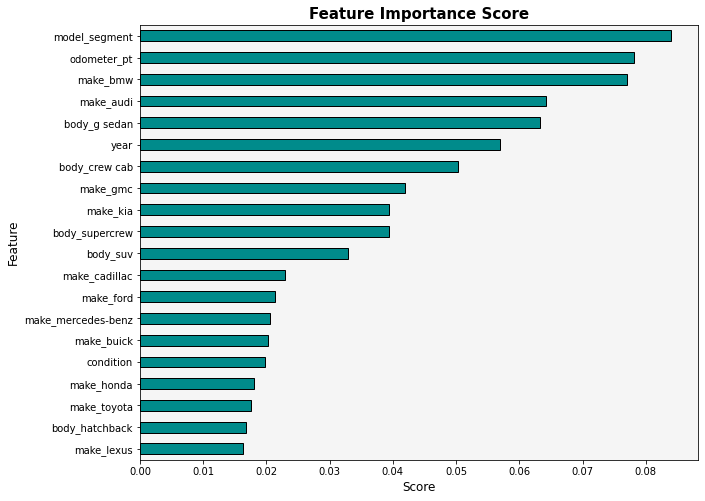

In [59]:
show_feature_importance(xg)

# 6. Linear Regression

In [60]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

evaluation(lr)

Train Score
MAE: 2680.79
RMSE: 3603.96
R2 score: 0.72
Test Score
MAE: 2692.27
RMSE: 3621.39
R2 score: 0.71


# 7. Lasso

In [61]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)

evaluation(lasso)

Train Score
MAE: 2680.53
RMSE: 3604.07
R2 score: 0.72
Test Score
MAE: 2692.20
RMSE: 3621.63
R2 score: 0.71


# 8. Ridge

In [62]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)

evaluation(ridge)

Train Score
MAE: 2680.79
RMSE: 3603.96
R2 score: 0.72
Test Score
MAE: 2692.27
RMSE: 3621.39
R2 score: 0.71


# 9. Decision Tree

In [63]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

evaluation(dt)

Train Score
MAE: 0.15
RMSE: 23.75
R2 score: 1.00
Test Score
MAE: 2219.68
RMSE: 3381.56
R2 score: 0.81


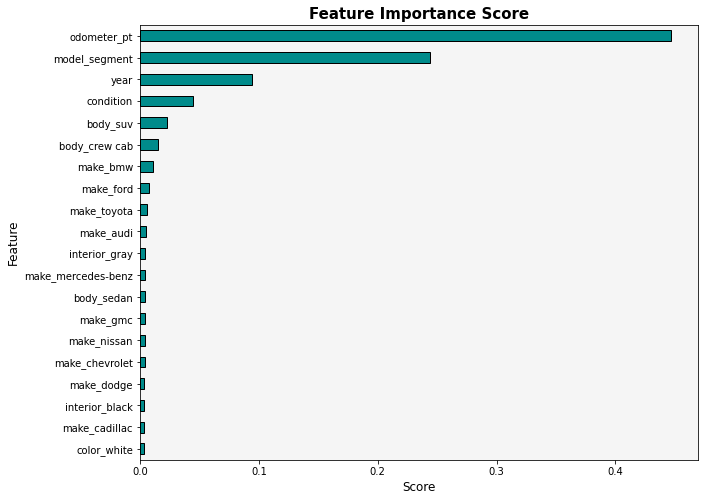

In [64]:
show_feature_importance(dt)

# 10. Adaboost

In [65]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state=42)
ada.fit(X_train, y_train)

evaluation(ada)

Train Score
MAE: 5022.14
RMSE: 5850.67
R2 score: -0.20
Test Score
MAE: 5020.61
RMSE: 5850.15
R2 score: -0.20


# 11. LGBM

In [66]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=198)
lgbm.fit(X_train, y_train)


evaluation(lgbm)

C:\Users\USER\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\USER\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\USER\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


Train Score
MAE: 1736.15
RMSE: 2504.31
R2 score: 0.88
Test Score
MAE: 1760.96
RMSE: 2548.60
R2 score: 0.87


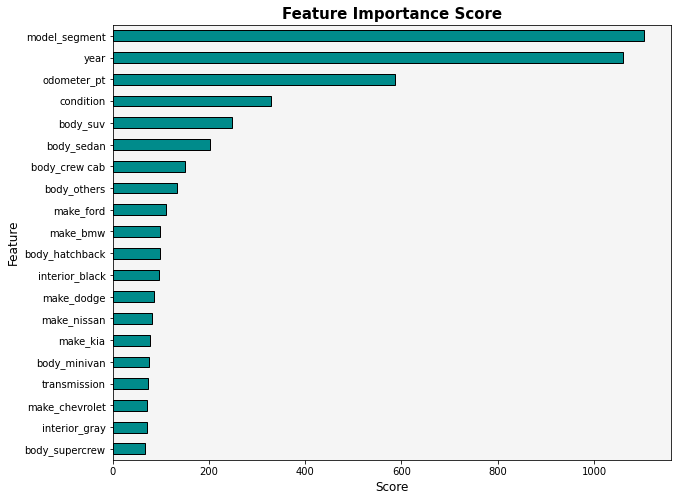

In [67]:
show_feature_importance(lgbm)

# 12. Hyperparamater Tuning

## a) LGBM

## Comparing the result

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
learning_rate = [0.9, 0,5]
min_data_in_leaf = [10, 5, 15, 20]
min_sum_hessian_in_leaf = [1, 10, 50, 100]
n_estimators = [10, 100, 200, 300, 500, 1000]
max_depth = [15, 10]
num_leaves = [10, 20]

hyperparameters = dict(max_depth=max_depth,
                       num_leaves=num_leaves,
                       n_estimators = n_estimators,
                        learning_rate=learning_rate,
                        min_data_in_leaf=min_data_in_leaf,
                        min_sum_hessian_in_leaf=min_sum_hessian_in_leaf
                      )

# Inisialisasi Model
lgbm = LGBMRegressor(n_estimators=198)
lgbm_tuned = RandomizedSearchCV(lgbm, hyperparameters, n_iter=15, cv=5, random_state=100, scoring='r2')
lgbm_tuned.fit(X_train, y_train)

# Eval Train
y_pred_train = lgbm_tuned.predict(X_train)
print('Train Score')
print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
print('='*50)

# Eval Test
y_pred_test = lgbm_tuned.predict(X_test)
print('Test Score')
print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Cu

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100


C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100


C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Cur

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1


C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1


C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Cu

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50


C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\USER\anaconda3\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "C:\Users\USER\anaconda3\li


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 wil

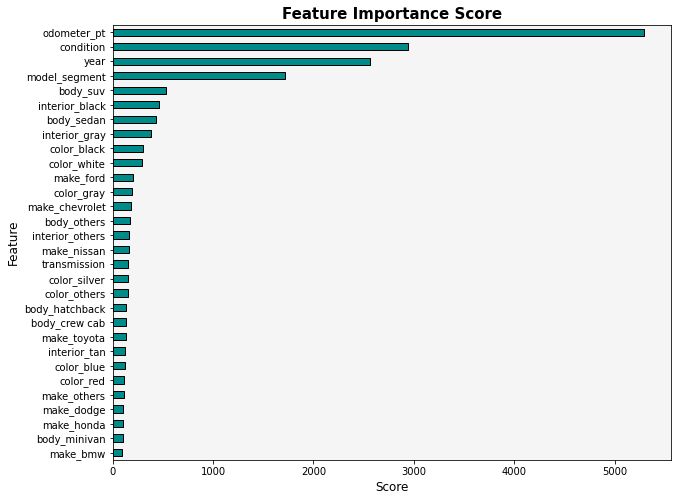

In [73]:
show_feature_importance(lgbm_tuned.best_estimator_)

In [80]:
result = pd.DataFrame({
    'ori': y_test,
    'pred': y_pred_test
})

result['pred'] = round(result['pred'], 2)

In [81]:
# absolute percentage error
result['APE'] = round(abs(result['pred']-result['ori'])/result['ori']*100, 2)

In [82]:
# mean absolute percentage error
MAPE = result.APE.sum()/len(result)
MAPE

19.10023716821028

In [83]:
diff = result['pred']-result['ori']
diff.sum()

-3774117.8900000006